In [11]:
import numpy as np
from collections import deque
from scipy.stats import t
import matplotlib.pyplot as plt
import rrcf
import warnings
import random
warnings.filterwarnings("ignore")

In [12]:
class RCTreeForest:
	"""
    A class to represent a forest of Random Cut Trees (RCTrees) for anomaly detection.

    Attributes:
        num_trees (int): Number of trees in the forest.
        tree_size (int): Maximum size of each tree.
        window_size (int): Maximum size of the data window.
        data_window (deque): Sliding window for recent data.
        index (int): Index counter for the data points.
        prev_score (float): Previous average codisplacement for anomaly detection.
        forest (list): List of RCTree objects.

    Methods:
        __init__(num_trees, tree_size, window_size):
            Initializes the RCTreeForest with the specified parameters.
        
        update_and_predict(new_data):
            Updates the forest with new data and predicts if the new data point is an anomaly.
            Args:
                new_data (float): The new data point to be added.
            Returns:
                int: -1 if an anomaly is detected, 1 if the data point is normal, None if an error occurs.
    """
	def __init__(self, num_trees, tree_size, window_size):
		try:
			# Check if parameters are positive integers
			if not all(isinstance(param, int) and param > 0 for param in [num_trees, tree_size, window_size]):
				raise ValueError("All parameters must be positive integers.")
			
			# Initialize the forest parameters
			self.num_trees = num_trees  # Number of trees in the forest
			self.tree_size = tree_size  # Maximum size of each tree
			self.window_size = window_size  # Maximum size of the data window
			
			# Initialize data structures
			self.data_window = deque(maxlen=window_size)  # Sliding window for recent data
			self.index = -1  # Initialize index counter
			self.prev_score = 0  # Store previous average codisplacement for anomaly detection
			
			# Initialize a forest of RCTree objects
			self.forest = [rrcf.RCTree() for _ in range(num_trees)]
		
		except ValueError as e:
			print(f"Error in initialization: {e}")  # Print error message for invalid parameters

	def update_and_predict(self, new_data):
		try:
			# Update index and append new data to the window
			self.index += 1
			self.data_window.append(new_data)
			avg_codisplacement = 0  # Initialize variable for average codisplacement

			# Iterate over each tree in the forest
			for tree in self.forest:
				# Forget points if the tree size exceeds limit
				if len(tree.leaves) > self.tree_size:
					tree.forget_point(self.index - self.tree_size)  # Remove the oldest point
				
				# Insert new point and calculate codisplacement
				tree.insert_point(self.data_window[-1], index=self.index)
				new_codisplacement = tree.codisp(self.index)
				avg_codisplacement += new_codisplacement / self.num_trees  # Aggregate codisplacement
				
			# Anomaly detection logic based on codisplacement threshold
			if self.index > self.tree_size + 1 and (avg_codisplacement >= 1.7 * self.prev_score or avg_codisplacement <= -1.7 * self.prev_score):
				self.prev_score = avg_codisplacement
				return -1  # Return -1 to signal potential anomaly
			else:
				self.prev_score = avg_codisplacement
				return 1  # Return 1 to signal normal behavior
			
		except Exception as e:
			print(f"Error in anomaly detection: {e}")  # Handle any runtime errors during update and prediction

In [13]:
class QuantileBasedAnomalyDetector:
	"""
    A class to detect anomalies in a data stream based on quantile thresholds.

    Attributes:
        window_size (int): Size of the sliding window for data.
        lower_quantile (float): Lower quantile threshold for anomaly detection.
        upper_quantile (float): Upper quantile threshold for anomaly detection.
        data_window (deque): Deque to manage the sliding window of data points.

    Methods:
        update_and_predict(new_data):
            Updates the sliding window with new data and predicts if the new data point is an anomaly.
            Args:
                new_data (float): The new data point to be added.
            Returns:
                int: -1 if an anomaly is detected, 1 if the data point is normal, None if an error occurs.
    """
	def __init__(self, window_size=100, lower_quantile=0.05, upper_quantile=0.95):
		# Initialize parameters for the anomaly detector
		self.window_size = window_size  # Size of the sliding window for data
		self.lower_quantile = lower_quantile  # Lower quantile for anomaly detection
		self.upper_quantile = upper_quantile  # Upper quantile for anomaly detection
		
		# Initialize a deque for managing the sliding window of data
		self.data_window = deque(maxlen=window_size)  # Keeps track of the most recent data points

	def update_and_predict(self, new_data):
		try:
			# Append new data to the sliding window
			self.data_window.append(new_data)

			# Ensure that there are enough data points in the window to calculate quantiles
			if len(self.data_window) < self.window_size:
				# Return None if we don't have enough data to make a prediction
				return 1  

			# Calculate the lower and upper quantile thresholds
			lower_bound = np.quantile(self.data_window, self.lower_quantile)
			upper_bound = np.quantile(self.data_window, self.upper_quantile)

			# Check if the new data point is outside the established bounds
			if new_data < lower_bound or new_data > upper_bound:
				return -1  # Return -1 to signal an anomaly detected
			
			return 1  # Return 1 to indicate normal behavior

		except Exception as e:
			print(f"Error in update and prediction: {e}")  # Handle any runtime errors

In [14]:
class EMAAnomalyDetector:
	"""
	A class to detect anomalies in a time series using the Exponential Moving Average (EMA).
	Attributes:
		alpha (float): Smoothing factor for EMA (0 < alpha <= 1).
		threshold (float): Threshold for anomaly detection.
		window_size (int): Size of the sliding window for storing data points.
		window_sum (float): Sum of the current window's data points.
		current_window_size (int): Current number of data points in the window.
		window (deque): Deque to store the most recent data points.
		ema (float or None): Current value of the Exponential Moving Average.
	Methods:
		update_and_predict(data):
			Updates the EMA with the new data point and predicts if it is an anomaly.
			Args:
				data (float): The new data point to be added.
			Returns:
				int: -1 if an anomaly is detected, 1 if the data point is normal, None if an error occurs.
	"""
	def __init__(self, alpha=0.3, threshold=3, window_size=100):
		# Initialize parameters for the Exponential Moving Average (EMA) anomaly detector
		self.alpha = alpha  # Smoothing factor for EMA (0 < alpha <= 1)
		self.threshold = threshold  # Threshold for anomaly detection
		self.window_size = window_size  # Size of the sliding window for storing data points
		
		# Initialize variables to manage the current state of the sliding window
		self.window_sum = 0  # Sum of the current window's data points
		self.current_window_size = 0  # Current number of data points in the window
		self.window = deque(maxlen=window_size)  # Deque to store the most recent data points
		self.ema = None  # Current value of the Exponential Moving Average

	def update_and_predict(self, data):
		try:
			# If the window is full, remove the oldest data point from the sum
			if len(self.window) == self.window_size:
				self.window_sum -= self.window[0]  # Subtract the oldest value
			
			# Append new data point to the window
			self.window.append(data)
			self.window_sum += data  # Update the sum with the new data point
			self.current_window_size = min(self.current_window_size + 1, self.window_size)  # Update the current window size
			
			# Calculate the EMA based on the current data
			if self.ema is None:
				self.ema = data  # Initialize EMA with the first data point
			else:
				window_mean = self.window_sum / self.current_window_size  # Calculate mean of the current window
				self.ema = self.alpha * window_mean + (1 - self.alpha) * self.ema  # Update EMA
			
			# Check if the current data point deviates significantly from the EMA
			if abs(data - self.ema) > self.threshold:
				return -1  # Return -1 to signal an anomaly detected
			
			return 1  # Return 1 to indicate normal behavior
		
		except Exception as e:
			print(f"Error in update and prediction: {e}")  # Handle any runtime errors
			return None  # Return None if an error occurs

In [15]:
class SHESDAnomalyDetector:
	"""
	SHESDAnomalyDetector is a class for detecting anomalies in time series data using Seasonal Hybrid Extreme Studentized Deviate (SH-ESD) method.
	Attributes:
		seasonality (int): The seasonality period of the time series data.
		alpha (float): The significance level for the anomaly detection.
		data_window (deque): A deque to store the data points within the seasonality window.
		window_mean (float): The mean of the data points in the current window.
		M2 (float): The sum of squares of differences from the current mean.
	Methods:
		__init__(seasonality=12, alpha=0.5):
			Initializes the SHESDAnomalyDetector with the given seasonality and alpha.
		update_and_predict(data):
			Updates the data window with the new data point and predicts if it is an anomaly.
			Args:
				data (float): The new data point to be added to the window.
			Returns:
				int: Returns -1 if the data point is an anomaly, otherwise returns 1.
	"""
	def __init__(self, seasonality = 12, alpha = 0.5):
		self.seasonality = seasonality
		self.alpha = alpha
		self.data_window = deque(maxlen = seasonality)
		self.window_mean = 0
		self.M2 = 0
		 
	
	def update_and_predict(self, data):
		try:
			# Update the data window and calculate mean and variance
			if len(self.data_window) == self.seasonality:
				# If the window is full, update mean and variance for existing data
				old_value = self.data_window[0]  # Get the oldest value in the window
				old_mean = self.window_mean  # Store the old mean
				self.window_mean += (data - old_value) / self.seasonality  # Update mean
				self.M2 += (data - old_value) * (data - self.window_mean + old_value - old_mean)  # Update M2
			else:
				# If the window is not full, just add the new data
				old_mean = self.window_mean  # Store the old mean
				self.window_mean += (data - old_mean) / (self.seasonality + 1)  # Update mean
				self.M2 += (data - old_mean) * (data - self.window_mean)  # Update M2
			
			# Append the new data point to the sliding window
			self.data_window.append(data)

			# Calculate variance and standard deviation
			variance = self.M2 / self.seasonality if len(self.data_window) > 1 else 0
			std_dev = np.sqrt(variance)  # Calculate standard deviation

			# Calculate the deviation from the mean
			deviation = abs(data - self.window_mean) 

			# Calculate the threshold for anomaly detection using the t-distribution
			threshold = std_dev * t.ppf(1 - self.alpha / 2, self.seasonality - 1)
			
			# Check if the deviation exceeds the threshold
			if deviation > threshold:
				return -1  # Return -1 to signal an anomaly detected
			else:
				return 1  # Return 1 to indicate normal behavior
		
		except Exception as e:
			print(f"Error in update and prediction: {e}")  # Handle any runtime errors
			return None  # Return None if an error occurs

In [16]:
class VotingEnsemble:
    """
    A class to implement a voting ensemble of anomaly detection algorithms.

    Attributes:
        detectors (list): A list of anomaly detection objects to be used in the ensemble.
        weights (list): A list of weights corresponding to each detector.

    Methods:
        __init__(detectors):
            Initializes the VotingEnsemble with the specified detectors and their weights.
        
        update_and_predict(data):
            Updates each detector with new data and predicts if the new data point is an anomaly.
            Args:
                data (float): The new data point to be evaluated.
            Returns:
                int: -1 if an anomaly is detected, 1 if the data point is normal, or None if an error occurs.
    """
    
    def __init__(self, detectors):
        """
        Initializes the VotingEnsemble with the specified detectors and their weights.

        Args:
            detectors (dict): A dictionary where keys are detector instances and values are their respective weights.
        """
        # Store the detectors and their corresponding weights
        self.detectors = detectors.keys()  # List of detector instances
        self.weights = detectors.values()   # List of weights for each detector
    
    def update_and_predict(self, data):
        """
        Updates each detector with new data and predicts if the new data point is an anomaly.

        Args:
            data (float): The new data point to be evaluated.

        Returns:
            int: -1 if an anomaly is detected, 1 if the data point is normal, or None if an error occurs.
        """
        # Get predictions from each detector
        predictions = [detector.update_and_predict(data) for detector in self.detectors]
        
        # Calculate weighted predictions based on the weights assigned to each detector
        weighted_predictions = [weight * prediction for weight, prediction in zip(self.weights, predictions)]
        
        # Compute the final ensemble prediction using the sign of the weighted sum
        ensemble_prediction = np.sign(sum(weighted_predictions))
        
        return ensemble_prediction

In [17]:
def visualize_stream(data_stream, anomalies):
    """
    Visualizes a data stream in real-time and highlights anomalies.

    Parameters:
        data_stream (iterable): An iterable of data points representing the data stream.
        anomalies (list of tuples): A list of tuples, where each tuple contains the (index, value) 
                                     of an anomaly to be highlighted in the plot.
    """
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots()  # Create a figure and axis for plotting
    x_vals = []  # List to hold x values (indices of the data stream)
    y_vals = []  # List to hold y values (data points)

    for i, value in enumerate(data_stream):
        x_vals.append(i)  # Append the index to x_vals
        y_vals.append(value)  # Append the current data point to y_vals

        ax.clear()  # Clear the current axis to prepare for new data
        ax.plot(x_vals, y_vals, label='Data Stream')  # Plot the data stream

        # Plot anomalies
        for anomaly in anomalies:
            ax.scatter(anomaly[0], anomaly[1], color='r', label='Anomaly')  # Highlight anomalies

        plt.pause(0.01)  # Pause to update the plot

    plt.ioff()  # Turn off interactive mode
    plt.show()  # Display the final plot


In [18]:
def generate_data_stream(pattern_length):
    """
    Generates a sinusoidal data stream based on the specified pattern length.

    Parameters:
        pattern_length (int): The number of data points to generate, must be a positive integer.

    Returns:
        numpy.ndarray: An array of generated sinusoidal values.

    Raises:
        ValueError: If pattern_length is not a positive integer.
    """
    try:
        # Validate the input
        if not isinstance(pattern_length, int) or pattern_length <= 0:
            raise ValueError("Pattern length must be a positive integer.")

        # Constants for the sinusoidal pattern
        n = pattern_length
        A = 50           # Amplitude
        center = 100     # Vertical shift
        phi = 30         # Phase shift
        T = 2 * np.pi / 100  # Frequency
        t = np.arange(n)  # Time array
        sin = A * np.sin(T * t - phi * T) + center  # Generate sinusoidal data

        return sin

    except ValueError as e:
        print(f"Error in generate_data_stream: {e}")


def add_anomalies_to_data(data_stream):
    """
    Adds anomalies to the provided data stream by randomly amplifying 10 values.

    Parameters:
        data_stream (list or np.ndarray): The data stream to which anomalies will be added.

    Raises:
        TypeError: If data_stream is not a list or a NumPy array.
    """
    try:
        # Validate the input
        if not isinstance(data_stream, (list, np.ndarray)):
            raise TypeError("Data stream must be a list or NumPy array.")

        # Randomly select indices to introduce anomalies
        indexs = random.sample(range(0, len(data_stream)), 10)
        for index in indexs:
            data_stream[index] *= 10  # Amplify the selected data points to create anomalies

    except TypeError as e:
        print(f"Error in add_anomalies_to_data: {e}")

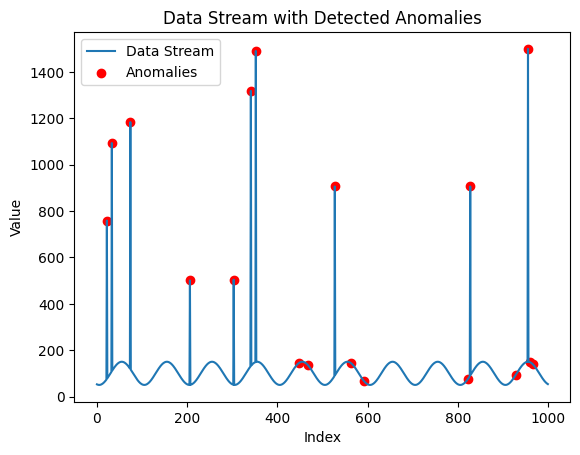

In [19]:
# Generate a data stream with 1000 points
data_stream = generate_data_stream(1000)

# Introduce anomalies to the generated data stream
add_anomalies_to_data(data_stream)

# Define the window size for the anomaly detection algorithms
window_size = 4

# Create a dictionary of anomaly detectors with their corresponding weights
detectors = {
    EMAAnomalyDetector(alpha=0.3, threshold=3, window_size=window_size): 1,
    SHESDAnomalyDetector(seasonality=window_size, alpha=0.5): 1,
    QuantileBasedAnomalyDetector(window_size=window_size, lower_quantile=0.05, upper_quantile=0.95): 1,
    RCTreeForest(num_trees=40, tree_size=256, window_size=window_size): 1
}

# Initialize the voting ensemble with the defined detectors
ensemble = VotingEnsemble(detectors)

# List to store detected anomalies
anomalies = []

# Process each data point in the data stream
for i, data in enumerate(data_stream):
    # Update the ensemble and get the prediction for the current data point
    prediction = ensemble.update_and_predict(data)
    
    # If an anomaly is detected, record its index and value
    if prediction == -1:
        anomalies.append((i, data))

# Plot the data stream
plt.plot(np.arange(1000), data_stream, label='Data Stream')

# Highlight detected anomalies in red
plt.scatter(*zip(*anomalies), color='r', label='Anomalies')

# Add labels and legend for clarity
plt.title('Data Stream with Detected Anomalies')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()